In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

# Next Steps

3. Clean workbook
4. Check if something more needs to be modularized.
5. rf004 Use multiple predictors in Random Forest


# Working Area

In [9]:
#---
# Hyperparameters rf002
#---
import pickle

predictors = ["sp", "tp", "u10", "v10",]
model_run = "rf002"
percentile = 0.99
pflag = str(percentile)[-2:]
folder = f"models/random_forest/{model_run}/"

print(f"model_run: {model_run}, percentile: {percentile}")
for predictor in predictors:
    fname = f"{model_run}_{predictor}{pflag}.pkl"

    with open(f"{folder}{fname}", 'rb') as f:
        data = pickle.load(f)

    print(predictor)
    print(data)

#---
# Hyperparameters rf003
#---
model_run = "rf003"
folder = f"models/random_forest/{model_run}/"

print(f"model_run: {model_run}, percentile: {percentile}")
for predictor in predictors:
    fname = f"{model_run}_{predictor}{pflag}.pkl"

    with open(f"{folder}{fname}", 'rb') as f:
        data = pickle.load(f)

    print(predictor)
    print(data)


model_run: rf002, percentile: 0.99
sp
{'min_samples_leaf': 2, 'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 100}
tp
{'min_samples_leaf': 2, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 100}
u10
{'min_samples_leaf': 2, 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 500}
v10
{'min_samples_leaf': 2, 'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 100}
model_run: rf003, percentile: 0.99
sp
{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
tp
{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
u10
{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
v10
{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


# Modularized Preprocessing

In [9]:
#---
# Modularize Preprocessing
#---

# Get timeseries of predictor and predictand
season = "winter" # ["winter", "autumn",] 
predictors = ["sp", "tp", "u10", "v10",]
percentile = 0.95 # [0.95, 0.99,] 
era5_import = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
station_names = ["hanko-han-fin-cmems",]

In [10]:
# Load already preprocessed Era5 Data
# Preprocessing done with cdo
#---
era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, era5_import)

In [11]:
#---
# Preprocess GESLA Data
#---

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)

# Subtract mean of data grouped by station
#---
gesla_predictand = gesla_predictand["sea_level"] # Detrend expects pd.Series
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

# Apply one hot encoding
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
gesla_predictand = gesla_predictand.to_xarray()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


In [35]:
#---
# Get overlapping time-series
#---
X, Y, t = preprocessing.intersect_time(era5_predictor, gesla_predictand)

print(f"X: {X.shape}")
print(f"Y: {Y.shape}")
print(f"t: {t.shape}")

Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)


In [38]:
# Reshape for model input
#---

ndim = t.shape[0]
X = X.reshape(ndim, -1) # (ndim, nclasses)
y = Y[:, 0] # Select one station
print(X.shape)
print(y.shape)

(903, 17061)
(903,)


In [39]:
#---
# Handle NaN Values
#---

# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

# Work Area

## Setup a model

In [42]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)
X_train.shape

(677, 17061)

In [43]:
#---
#  Optimize Hyperparameters
#---
def optimize_hyperparameter(X_train, y_train, clf, optimizer, param_grid, k, n_iter=None, n_jobs=-1):
    """
    Description: 
        Return best hyperparameters for a model based on chosen optimizer
    Parameters:
        X_train (): Predictor train data
        y_train (): Predictand train data

        clf (): Base Model
        optimizer (): GridSearchCV or RandomizedSearchCV
        param_grid (dict): Dictionary with hyperparameter ranges
        k (int): k-fold Cross-Validation
        n_iter (int): Number of combinations used for RandomizedSearchCV (Defaults:None)
        n_jobs (int): Number of processor used. (Defaults:-1, e.g. all processors)
    """
    # Modules
    #---
    from sklearn.model_selection import GridSearchCV 
    from sklearn.model_selection import RandomizedSearchCV
    # RandomSearchCV
    #---
    print(f"Optimize Hyperparameters using {optimizer}")

    if optimizer == "RandomSearchCV":
        assert n_iter != None, f"{optimizer} needs number of combinations."
        opt_model = RandomizedSearchCV(estimator=clf, 
        param_distributions = param_grid, 
        n_iter = n_iter, 
        cv = k, 
        verbose = 2, 
        random_state = 0, 
        n_jobs = n_jobs,
        )

    # GridSearchCV
    #---
    if optimizer == "GridSearchCV":
        # Instantiate the grid search model
        opt_model = GridSearchCV(estimator=clf, 
        param_grid = param_grid, 
        cv = k,
        verbose = 2, 
        n_jobs = n_jobs, 
        )

    # Fit the random search model
    opt_model.fit(X_train, y_train)

    # Best Params
    #---
    return opt_model.best_params_


In [ ]:
def optimize_hyperparameter(X_train, y_train, clf, optimizer, param_grid, k, n_iter=None, n_jobs=-1):
        """
        Description: 
            Return best hyperparameters for a model based on chosen optimizer
        Parameters:
            X_train (): Predictor train data
            y_train (): Predictand train data

            clf (): Base Model
            optimizer (): GridSearchCV or RandomizedSearchCV
            param_grid (dict): Dictionary with hyperparameter ranges
            k (int): k-fold Cross-Validation
            n_iter (int): Number of combinations used for RandomizedSearchCV (Defaults:None)
            n_jobs (int): Number of processor used. (Defaults:-1, e.g. all processors)
        """
        # Modules
        #---
        from sklearn.model_selection import GridSearchCV 
        from sklearn.model_selection import RandomizedSearchCV
        # RandomSearchCV
        #---
        print(f"Optimize Hyperparameters using {optimizer}")

        if optimizer == "RandomSearchCV":
            assert n_iter != None, f"{optimizer} needs number of combinations."
            opt_model = RandomizedSearchCV(estimator=clf, 
            param_distributions = param_grid, 
            n_iter = n_iter, 
            cv = k, 
            verbose = 2, 
            random_state = 0, 
            n_jobs = n_jobs,
            )

        # GridSearchCV
        #---
        if optimizer == "GridSearchCV":
            # Instantiate the grid search model
            opt_model = GridSearchCV(estimator=clf, 
            param_grid = param_grid, 
            cv = k,
            verbose = 2, 
            n_jobs = n_jobs, 
            )

        # Fit the random search model
        opt_model.fit(X_train, y_train)

        # Best Params
        #---
        return opt_model.best_params_

In [44]:
#---
#  Optimize Hyperparameters
#---
clf = RandomForestClassifier()
optimizer = "RandomSearchCV"
k = 3 # k-fold cross-validation
n_iter = 100 # number of combinations

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(f"Tested Hyperparameters: {param_grid}")

best_params = optimize_hyperparameter(X_train, y_train, clf, optimizer, param_grid, k, n_iter=n_iter, n_jobs=-1)

Tested Hyperparameters: {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [54]:
# Save hyperparameters
model_run = f"RandomForest_{optimizer}"
folder = "results/random_forest/" 
saver.save_hpdict(best_params, predictor, model_run, percentile, folder)

In [46]:
# Fit the model
model = RandomForestClassifier(criterion='gini',
n_estimators=best_params["n_estimators"], #- nTrees 
max_depth=best_params["max_depth"], 
max_features=best_params["max_features"],
min_samples_leaf=best_params["min_samples_leaf"],
min_samples_split=best_params["min_samples_split"],
bootstrap=best_params["bootstrap"],
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=600, oob_score=True, random_state=0)

In [47]:
# Saving the model
filename = f'RandomForest_{optimizer}.sav'
pickle.dump(model, open(f'{folder}{filename}', 'wb'))

In [50]:
# Load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features='sqrt', min_samples_leaf=2,
                       n_estimators=600, oob_score=True, random_state=0)>

## Evaluate the model

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
(903, 17061)
(903,)
Evaluate Model 

test_score: 0.8893805309734514
train_score: 1.0
importances: [2.81286683e-04 1.19415172e-04 1.26645434e-04 ... 9.83907397e-05
 5.47066618e-06 1.73993762e-05]
saved importances to : models/random_forest/rf003/importances_sp95
Show Confusion Matrix 

saved cf matrix to : models/random_forest/rf003/cf_matrix_sp95.jpg


C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


Metric values 

tnr: 0.9441624365482234
tpr: 0.5172413793103449
gmean: 0.6988275044481428
wacc: 0.7307019079292841
precision: 0.5769230769230769
recall: 0.5172413793103449
fmeasure: 0.5454545454545454
saved cf metrics to : cf_metrics_sp95.pkl
Show AUROC 

AUC: 0.8802730614388237


C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:168: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : models/random_forest/rf003/AUROC_sp95.jpg
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
(903, 17061)
(903,)
Evaluate Model 

test_score: 0.8628318584070797
train_score: 1.0
importances: [3.86737222e-05 5.64933790e-05 3.61813122e-05 ... 0.00000000e+00
 3.41596253e-05 6.83162439e-05]
saved importances to : models/random_forest/rf003/importances_tp95
Show Confusion Matrix 

saved cf matrix to : models/random_forest/rf003/cf_matrix_tp95.jpg


C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


Metric values 

tnr: 0.9796954314720813
tpr: 0.06896551724137931
gmean: 0.2599330724830689
wacc: 0.5243304743567303
precision: 0.3333333333333333
recall: 0.06896551724137931
fmeasure: 0.1142857142857143
saved cf metrics to : cf_metrics_tp95.pkl
Show AUROC 

AUC: 0.8538421144757571


C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:168: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : models/random_forest/rf003/AUROC_tp95.jpg
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
(903, 17061)
(903,)
Evaluate Model 

test_score: 0.8672566371681416
train_score: 0.9852289512555391
importances: [3.30822191e-05 5.09220351e-05 1.84451581e-04 ... 0.00000000e+00
 7.21407244e-05 2.02430134e-05]
saved importances to : models/random_forest/rf003/importances_u1095
Show Confusion Matrix 



C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : models/random_forest/rf003/cf_matrix_u1095.jpg
Metric values 

tnr: 0.9289340101522843
tpr: 0.4482758620689655
gmean: 0.6453051171393238
wacc: 0.6886049361106249
precision: 0.48148148148148145
recall: 0.4482758620689655
fmeasure: 0.4642857142857143
saved cf metrics to : cf_metrics_u1095.pkl
Show AUROC 

AUC: 0.8750218799229826


C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:168: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : models/random_forest/rf003/AUROC_u1095.jpg
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
(903, 17061)
(903,)
Evaluate Model 

test_score: 0.8805309734513275
train_score: 1.0
importances: [8.70656027e-04 3.95476314e-04 1.19612168e-03 ... 0.00000000e+00
 5.80943809e-05 0.00000000e+00]
saved importances to : models/random_forest/rf003/importances_v1095
Show Confusion Matrix 

saved cf matrix to : models/random_forest/rf003/cf_matrix_v1095.jpg


C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:129: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
C:\Users\Kai\AppData\Local\Temp\ipykernel_5172\1014038090.py:168: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Metric values 

tnr: 0.9898477157360406
tpr: 0.13793103448275862
gmean: 0.36950063519819243
wacc: 0.5638893751093996
precision: 0.6666666666666666
recall: 0.13793103448275862
fmeasure: 0.2285714285714286
saved cf metrics to : cf_metrics_v1095.pkl
Show AUROC 

AUC: 0.8582180990722913
saved AUROC to : models/random_forest/rf003/AUROC_v1095.jpg


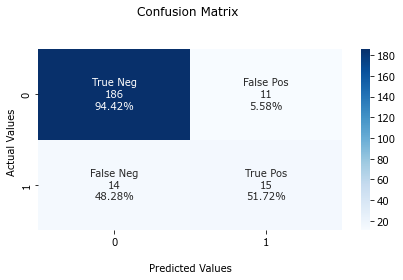

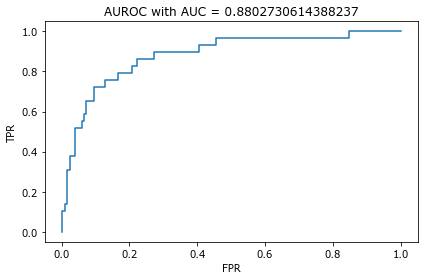

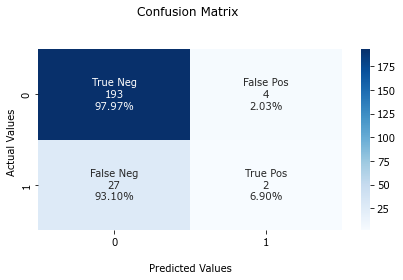

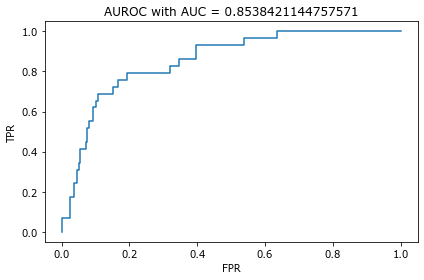

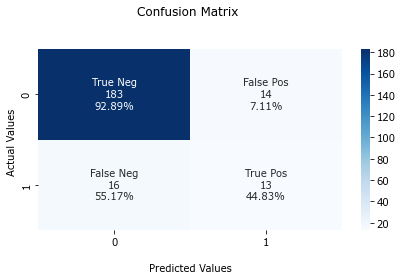

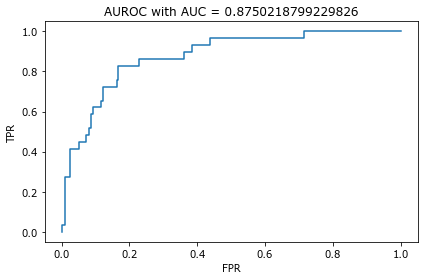

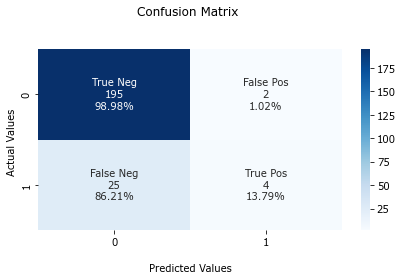

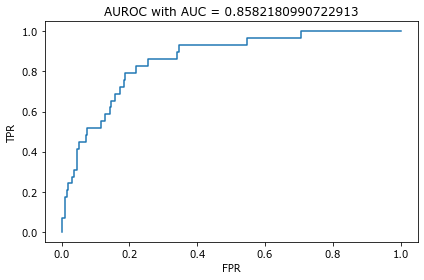

In [15]:
#---
# Get Train-Test Split
#---
# Get timeseries of predictor and predictand
from data import data_loader

season = "winter" # ["winter", "autumn",] 
predictors = ["sp", "tp", "u10", "v10",]
percentile = 0.99 # [0.95, 0.99,] 
era5_import = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
station_names = ["hanko-han-fin-cmems",]

for predictor in predictors:
    # Load already preprocessed Era5 Data
    # Preprocessing done with cdo
    #---
    era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, era5_import)

    #---
    # Preprocess GESLA Data
    #---

    # Load Predictand
    #---
    gesla_predictand = data_loader.load_gesla(station_names)

    # Select a season
    #---
    gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

    # Select only sea_level analysis data
    #---
    gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)

    # Subtract mean of data grouped by station
    #---
    gesla_predictand = gesla_predictand["sea_level"] # Detrend expects pd.Series
    gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

    # Apply one hot encoding
    gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
    print(f"Applied one-hot-encoding with Percentile: {percentile}")

    # Convert to DataArray
    # nan values: no measurement at that timestamp for specific station
    gesla_predictand = gesla_predictand.to_xarray()

    #---
    # Get overlapping time-series
    #---
    X, Y, t = preprocessing.intersect_time(era5_predictor, gesla_predictand)

    print(f"X: {X.shape}")
    print(f"Y: {Y.shape}")
    print(f"t: {t.shape}")

    # Reshape for model input
    #---

    ndim = t.shape[0]
    X = X.reshape(ndim, -1) # (ndim, nclasses)
    y = Y[:, 0] # Select one station
    print(X.shape)
    print(y.shape)

    #---
    # Handle NaN Values
    #---

    # Insert numerical value that is not in data.
    # ML will hopefully recognize it.
    X[np.where(np.isnan(X))] = -999

    #---
    # Train Model
    #---
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    import pickle

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

    #---
    # Load Model
    #---
    import pickle
    percentile = 0.99
    pflag = str(percentile)[-2:]
    folder = f"models/random_forest/rf003/"
    fname = f"RandomForest_RandomSearchCV_{predictor}{pflag}.sav"
    
    model = pickle.load(open(f"{folder}{fname}", 'rb'))

    #---
    # Evaluate model / Diagnostic
    #--- 
    print("Evaluate Model \n")

    # Score & Importance
    #---
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
    importances = model.feature_importances_

    print(f"test_score: {test_score}")
    print(f"train_score: {train_score}")
    print(f"importances: {importances}")

    fname = f"importances_{predictor}{str(percentile)[-2:]}"
    np.save(f"{folder}{fname}", importances)
    print(f"saved importances to : {folder}{fname}")

    # Confusion matrix
    #---
    # Format: 
    # Reality / Model: Negative, Positive
    # Negative    Right Negative, False Positive 
    # Positive    False Negative, Right Positive

    from sklearn.metrics import confusion_matrix
    from models import evaluation

    print("Show Confusion Matrix \n")

    cfm_fig = evaluation.plot_cf(model, X_test, y_test)
    cfm_fig.show()

    # Save CFM
    fname = f"{folder}cf_matrix_{predictor}{str(percentile)[-2:]}.jpg"
    cfm_fig.savefig(fname)
    print(f"saved cf matrix to : {fname}")

    # Calculate CFM-Metrics
    metrics = evaluation.cfm_metrics(model, X_test, y_test)
    fname = f"cf_metrics_{predictor}{str(percentile)[-2:]}.pkl"

    with open(f"{folder}{fname}", 'wb') as f:
        pickle.dump(metrics, f)

    print(f"saved cf metrics to : {fname}")


    # AUROC
    # Receiver Operating Characteristics & Area Under the Curve
    #---
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    print("Show AUROC \n")

    y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    auc = roc_auc_score(y_test, y_test_proba)

    print(f'AUC: {auc}')

    fig, ax = plt.subplots(tight_layout=True)

    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"AUROC with AUC = {auc}")

    fig.show()

    fname = f"{folder}AUROC_{predictor}{str(percentile)[-2:]}.jpg"
    fig.savefig(fname)
    print(f"saved AUROC to : {fname}")

# Not Modularized Examples

In [2]:
# ---
# Preprocessing
# ---

model_run = "rf002"

# Get timeseries of predictor and predictand
percentile = 0.95
predictors = ["sp", "tp", "u10", "v10",]
predictor = "sp"
season = "winter"


X, Y, t = preprocessing.preprocessing1(season, predictor, percentile)

# Handle NaN values: 
# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

# Save number of lat/lon for interpreting model output later
ndim = X.shape[0]
nlat = X.shape[1]
nlon = X.shape[2]

# Prepare shape for model
X = X.reshape(ndim, -1) # (ndim, nclasses)
y = Y[:, 0] # Select only one station

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding
Get overlapping timeseries of ERA5 and GESLA


In [17]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# Load Hyperparameters
folder = "models/random_forest/hyperparameter/"
fname = f"{model_run}_{predictor}{str(percentile)[-2:]}.pkl"

with open(f"{folder}{fname}", 'rb') as f:
    params = pickle.load(f)

params
# Fit the model
model = RandomForestClassifier(criterion='gini',
n_estimators=params["n_estimators"], #- nTrees 
max_depth=params["max_depth"], 
min_samples_leaf=params["min_samples_leaf"],
min_samples_split=params["min_samples_split"],
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)
#---
# Evaluate model / Diagnostic
#--- 
# Score & Importance
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
importances = model.feature_importances_

print(f"test_score: {test_score}")
print(f"train_score: {train_score}")
print(f"importances: {importances}")

%matplotlib inline
#---
#  Diagnostics
#---

# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

from sklearn.metrics import confusion_matrix
from models import evaluation

y_test_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)

cfm_fig = evaluation.plot_cf(model, X_test, y_test)
metrics = evaluation.cfm_metrics(model, X_test, y_test)

# # Save results
# folder = "results/"
# fname = f"{folder}cf_matrix.png"
# cfm_fig.savefig(fname)

{'min_samples_leaf': 2,
 'max_depth': 10,
 'min_samples_split': 4,
 'n_estimators': 500}

In [ ]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# Load Hyperparameters
folder = "models/random_forest/hyperparameter/"
fname = f"{model_run}_{predictor}{str(percentile)[-2:]}.pkl"

with open(f"{folder}{fname}", 'rb') as f:
    params = pickle.load(f)

params
# Fit the model
model = RandomForestClassifier(criterion='gini',
n_estimators=params["n_estimators"], #- nTrees 
max_depth=params["max_depth"], 
min_samples_leaf=params["min_samples_leaf"],
min_samples_split=params["min_samples_split"],
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)
#---
# Evaluate model / Diagnostic
#--- 
# Score & Importance
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
importances = model.feature_importances_

print(f"test_score: {test_score}")
print(f"train_score: {train_score}")
print(f"importances: {importances}")

%matplotlib inline
#---
#  Diagnostics
#---

# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

from sklearn.metrics import confusion_matrix
from models import evaluation

y_test_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)

cfm_fig = evaluation.plot_cf(model, X_test, y_test)
metrics = evaluation.cfm_metrics(model, X_test, y_test)

# # Save results
# folder = "results/"
# fname = f"{folder}cf_matrix.png"
# cfm_fig.savefig(fname)

{'min_samples_leaf': 2,
 'max_depth': 10,
 'min_samples_split': 4,
 'n_estimators': 500}

AUC: 0.889637668475407


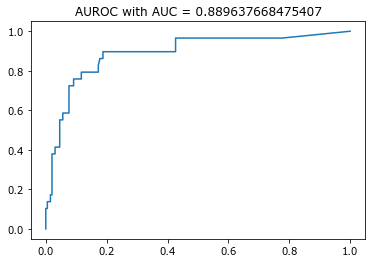

In [4]:
# AUROC
# Receiver Operating Characteristics & Area Under the Curve
#---
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f'AUC: {auc}')

fig, ax = plt.subplots()

plt.plot(fpr, tpr)
plt.title(f"AUROC with AUC = {auc}")
plt.show()

In [ ]:
#--- 
# Optimization of HP with VC
#---
from models.random_forest import rf002

percentiles = [0.95, 0.99]
for percentile in percentiles:
    rf002.optimization(percentile)

In [ ]:
#---
# Reading hparams from VC and save it
#---
from models.random_forest import rf002

predictor = "v10"
percentile = 0.95

min_samples_leaf = 4
max_depth = 10
min_samples_split = 4
n_estimators = 100

hparams = (min_samples_leaf, max_depth, min_samples_split, n_estimators)
rf002.save_hp(hparams, predictor, model_run="rf002", percentile=percentile,)

In [ ]:
# Postprocessing

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter


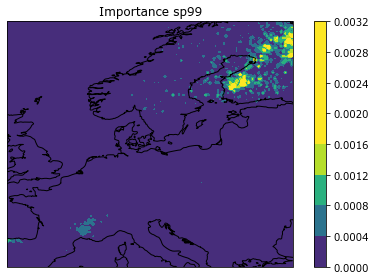

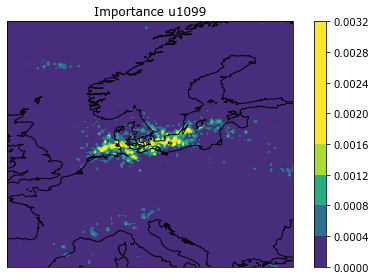

In [2]:
#---
# Visualization
#---

# Metric: Importance
#---
from data import preprocessing

# Initialize
model_run = "rf003"
predictors = ["sp", "u10",]
percentiles = [0.99,] #0.99,]
range_of_years = "1999-2008"
subregion = "lon-0530_lat7040"
season = "winter"
preprocess = "preprocess1"

for predictor in predictors:
    for percentile in percentiles:
        # Load importance
        folder = f"results/random_forest/{model_run}/"
        fname = f"importances_{predictor}{str(percentile)[-2:]}"
        importance = np.load(f"{folder}{fname}.npy")

        # Load lat lons
        lats, lons = preprocessing.get_lonlats(
            range_of_years,
            subregion,
            season,
            predictor,
            preprocess,
        )

        # Plot importance-map
        from models import evaluation
        tflag = f"{predictor}{str(percentile)[-2:]}"
        fig = evaluation.importance_map(importance, lons, lats, tflag=tflag)

        # Save importance-map
        folder = f"results/random_forest/{model_run}/"
        fname = f"importance_map_{predictor}{str(percentile)[-2:]}"
        fig.savefig(f"{folder}{fname}.jpg")